# Decision Trees

We will have a look at the `Carseats` data using the `tree` package in R,
as in the lab in the book.


In [1]:
require(ISLR)
# install.packages("tree")
require(tree)


Loading required package: ISLR

Loading required package: tree



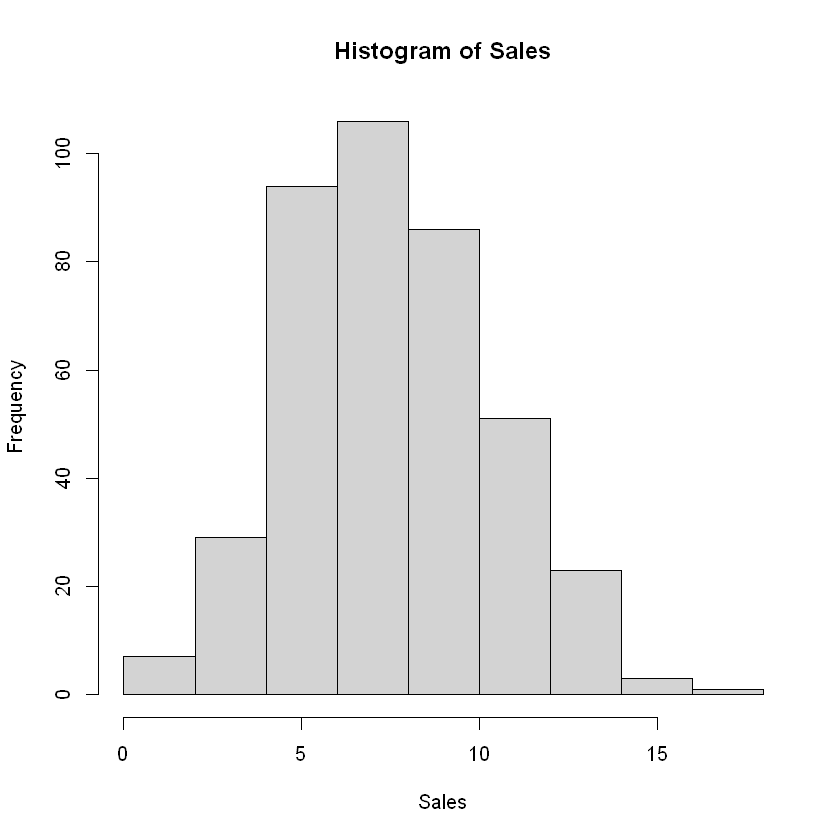

In [2]:
attach(Carseats)
hist(Sales)


In [3]:
# We create a binary reponse variable `High` (for high sales), and we include
# it in the same dataframe.

# Turn sales into a binary variable. If sales is less than or equal to 8
# It is not high, otherwise it is.
High <- ifelse(Sales <= 8, "No", "Yes")
High <- factor(High, levels = c("No", "Yes"))
# Create a dataframe with High as a new column.
Carseats <- data.frame(Carseats, High)
summary(Carseats)


     Sales          CompPrice       Income        Advertising    
 Min.   : 0.000   Min.   : 77   Min.   : 21.00   Min.   : 0.000  
 1st Qu.: 5.390   1st Qu.:115   1st Qu.: 42.75   1st Qu.: 0.000  
 Median : 7.490   Median :125   Median : 69.00   Median : 5.000  
 Mean   : 7.496   Mean   :125   Mean   : 68.66   Mean   : 6.635  
 3rd Qu.: 9.320   3rd Qu.:135   3rd Qu.: 91.00   3rd Qu.:12.000  
 Max.   :16.270   Max.   :175   Max.   :120.00   Max.   :29.000  
   Population        Price        ShelveLoc        Age          Education   
 Min.   : 10.0   Min.   : 24.0   Bad   : 96   Min.   :25.00   Min.   :10.0  
 1st Qu.:139.0   1st Qu.:100.0   Good  : 85   1st Qu.:39.75   1st Qu.:12.0  
 Median :272.0   Median :117.0   Medium:219   Median :54.50   Median :14.0  
 Mean   :264.8   Mean   :115.8                Mean   :53.32   Mean   :13.9  
 3rd Qu.:398.5   3rd Qu.:131.0                3rd Qu.:66.00   3rd Qu.:16.0  
 Max.   :509.0   Max.   :191.0                Max.   :80.00   Max.   :18.0  


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

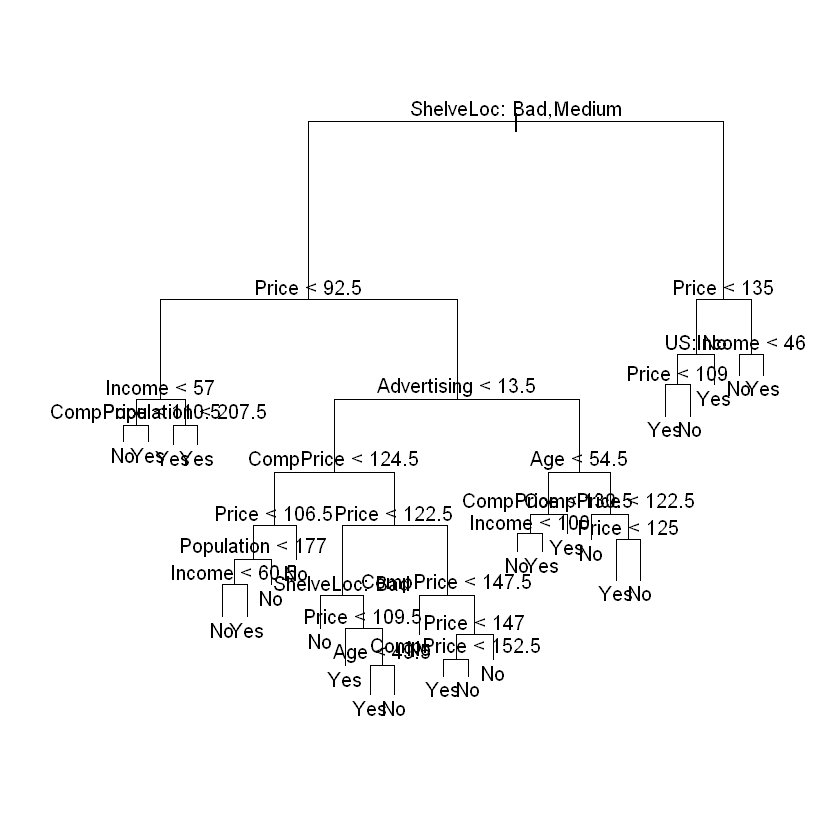

In [4]:
# Now we are going to fit a model using trees, summarize and plot it.
# Notice that we have to exclude `Sales` from the right hand side of the
# formula, beacause the reponse (High) is derived from it.
tree.carseats <- tree(High ~ . - Sales, data = Carseats)
summary(tree.carseats)
plot(tree.carseats)
text(tree.carseats, pretty = 0)


In [5]:
# For a detailed version of the tree, print it:
tree.carseats
length(Carseats)

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

[1] 12

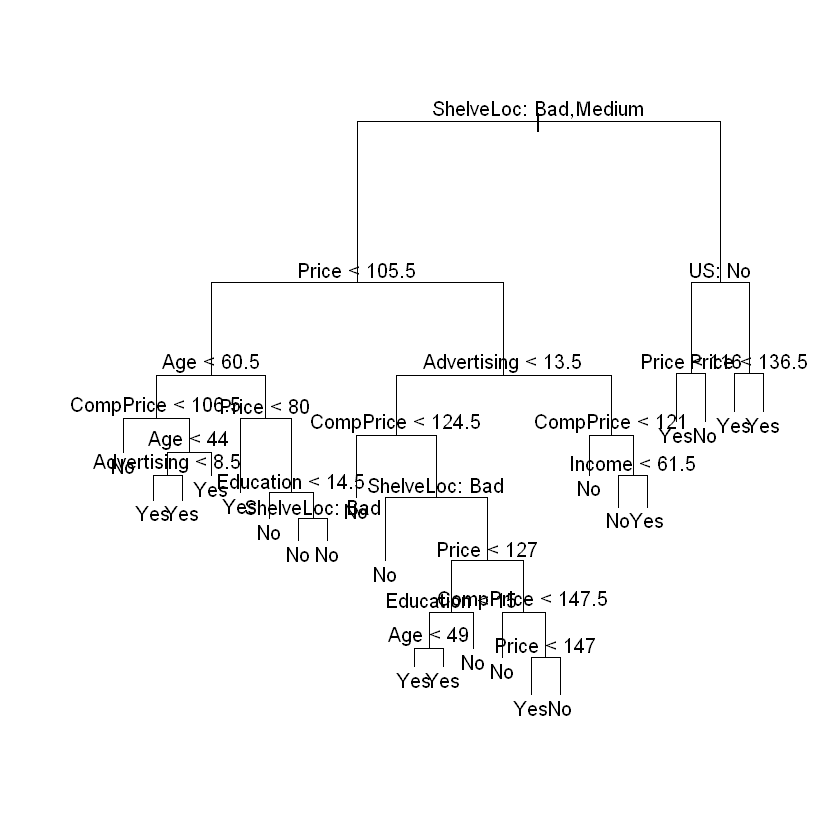

In [6]:
# Let's create a training and test set (250, 150) split of the 400 observations
# grow the tree on the training set, and evaluate it's performance on the test set.
set.seed(1011)
train <- sample(1:nrow(Carseats), 250)
tree.carseats <- tree(High ~ . - Sales, Carseats, subset = train)
plot(tree.carseats)
text(tree.carseats, pretty = 0)


In [7]:
# Predict the tree on the test set

# remove the training observations, which
# will of course leave the test observations.
# type="class" because you can make different types of predictions,
# in particular you can predict the probabilities.
# Here we want to actually predict the class labels.
tree.pred <- predict(tree.carseats, Carseats[-train, ], type = "class")
# With is a handy way of assigning the data frame as the context in which
# to do the next command (table)
with(Carseats[-train, ], table(tree.pred, High))
# So there we get a little misclassification table:
# On the diagonals are the correct classifications.
# On the off diagonals are the incorrect classifications.


         High
tree.pred No Yes
      No  58  20
      Yes 27  45

In [13]:
# So we'll take the sum of the two diagonals divided by the
# total, which is 150 here. And we see that we get an error rate
# of 0.71 with this tree.
(58 + 45) / 150


[1] 0.6866667

$size
 [1] 23 17 16 14 10  8  6  5  4  2  1

$dev
 [1]  64  61  69  67  70  81  80  83  81  81 101

$k
 [1] -Inf  0.0  1.0  1.5  2.0  3.0  3.5  5.0  6.0  7.0 27.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

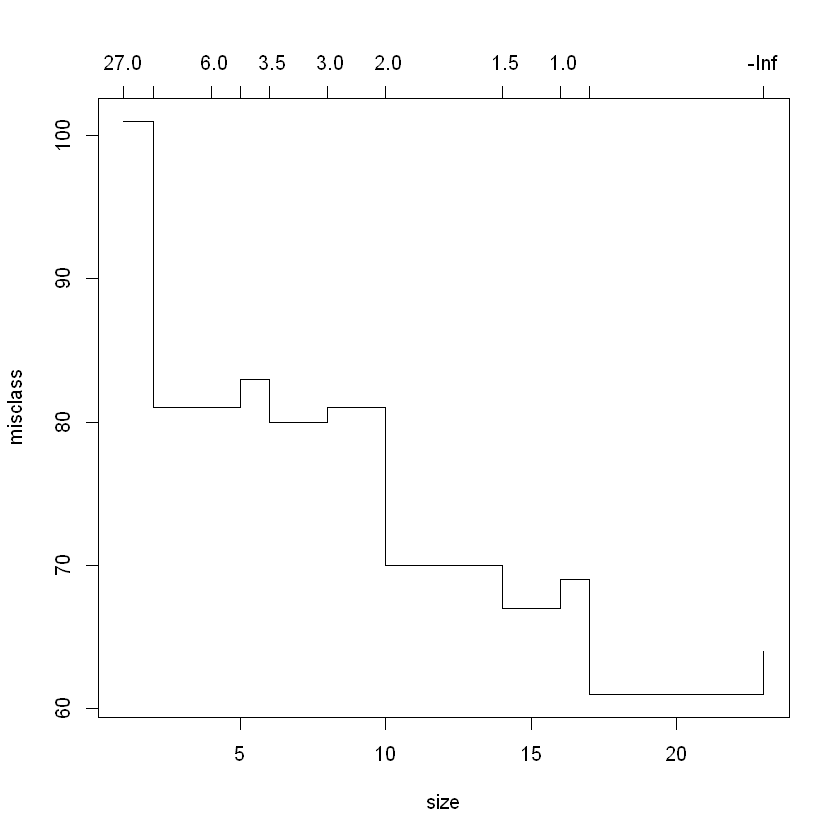

In [14]:
# So we know that when we grow a bushy tree, it could have too much variance.
# And so now we're going to use cross-validation to prune the tree optimally.
# use misclassification error as the basis for doing the pruning.
cv.carseats <- cv.tree(tree.carseats, FUN = prune.misclass)
# So this will do tenfold cross-validation for us and we can print out the results.
cv.carseats
plot(cv.carseats)

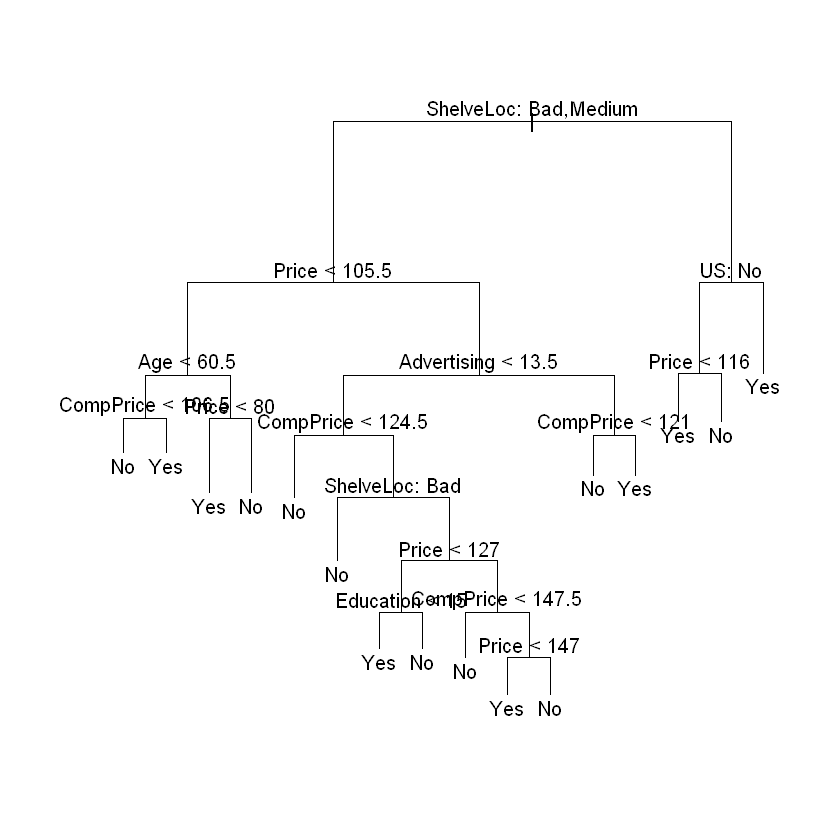

In [15]:
# Let's prune our tree to size 18 which is around the minimum.
prune.carseats <- prune.misclass(tree.carseats, best = 16)
plot(prune.carseats)
text(prune.carseats, pretty = 0)


In [18]:
# Now let's evaluate the pruned tree on our test data set.
tree.pred <- predict(prune.carseats, Carseats[-train, ], type = "class")
with(Carseats[-train, ], table(tree.pred, High))
(59 + 47) / 150

         High
tree.pred No Yes
      No  59  18
      Yes 26  47

[1] 0.7066667